# CIFAR-10 Image Classification with CNN: Training and Evaluation

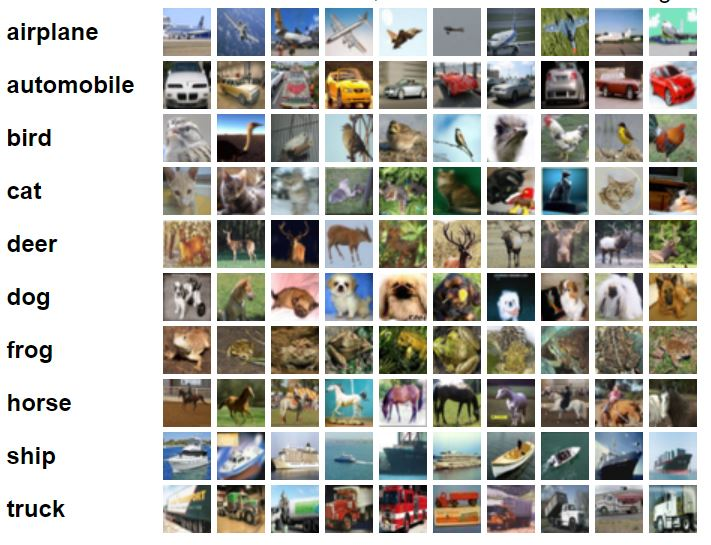

# About the CIFAR-10 Dataset

CIFAR-10 is ideal for training and testing image classification models, particularly for Convolutional Neural Networks (CNNs). It serves as a fundamental benchmark for researchers and developers working on low-resolution image classification tasks. It consists of 60,000 color images, each sized 32x32 pixels, divided into 10 distinct classes, each representing a different object or creature:

- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

Each class contains an equal distribution of 6,000 images. From the total image count, 50,000 images are designated for training, while the remaining 10,000 images are reserved for testing.


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import urllib.request
import requests
import cv2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# Load Data

In [2]:
from tensorflow.keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [4]:
X_train[12].shape

(32, 32, 3)

In [5]:
X_train[12]

array([[[164, 215, 244],
        [162, 212, 240],
        [162, 212, 240],
        ...,
        [157, 210, 237],
        [153, 208, 235],
        [153, 203, 234]],

       [[168, 218, 245],
        [166, 215, 242],
        [166, 215, 242],
        ...,
        [164, 212, 238],
        [160, 209, 236],
        [158, 205, 235]],

       [[172, 220, 246],
        [170, 217, 243],
        [171, 218, 244],
        ...,
        [168, 212, 238],
        [165, 208, 235],
        [163, 207, 236]],

       ...,

       [[123, 160, 105],
        [117, 154, 102],
        [112, 149,  99],
        ...,
        [117, 136, 100],
        [ 95, 115,  79],
        [120, 149, 100]],

       [[120, 156, 100],
        [116, 151,  99],
        [112, 147,  96],
        ...,
        [126, 149, 110],
        [120, 144, 103],
        [120, 152, 101]],

       [[121, 154,  96],
        [120, 152,  99],
        [116, 148,  97],
        ...,
        [124, 152, 108],
        [124, 154, 107],
        [120, 154, 100]]

# Visualization

In [6]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def plot_sample(X, y, index):
    plt.figure(figsize=(15, 2))
    plt.imshow(X[index])  
    plt.xlabel(class_names[y[index].item()]) 
    plt.show()

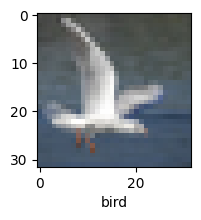

In [7]:
plot_sample(X_test, y_test, 2542)

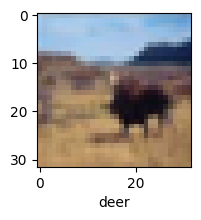

In [8]:
plot_sample(X_test, y_test, 165)

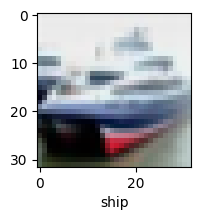

In [9]:
plot_sample(X_test, y_test, 1)

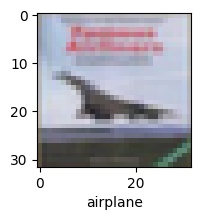

In [10]:
plot_sample(X_test, y_test, 3)

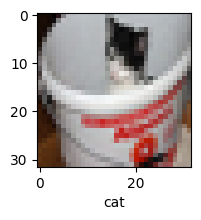

In [11]:
plot_sample(X_test, y_test, 4962)

# Building the CNN Model

In [12]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [13]:
model = models.Sequential([

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),  
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),  

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),  
    
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    
    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  
    layers.Dropout(0.5),  
    
    layers.Dense(num_classes, activation='softmax') 
])


In [14]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [15]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [16]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
               epochs=50,
               validation_data=(X_test, y_test),
               callbacks=[early_stopping])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728823626.367487     100 service.cc:145] XLA service 0x7e2cd8003110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728823626.367594     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728823626.367599     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   7/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.1013 - loss: 5.8189 

I0000 00:00:1728823636.778141     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 63s 30ms/step - accuracy: 0.3572 - loss: 2.8307 - val_accuracy: 0.5103 - val_loss: 1.5480
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.5886 - loss: 1.2388 - val_accuracy: 0.6085 - val_loss: 1.2603
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.6706 - loss: 1.0474 - val_accuracy: 0.6676 - val_loss: 1.1115
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.7029 - loss: 0.9628 - val_accuracy: 0.7655 - val_loss: 0.7892
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.7333 - loss: 0.8918 - val_accuracy: 0.7093 - val_loss: 0.9956
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.7502 - loss: 0.8500 - val_accuracy: 0.7660 - val_loss: 0.8033
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.7665 - loss: 0.7983 - val_accuracy: 0.7944 - val_loss: 0.7413
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.7794 - loss: 0.76

# Evaluate the Model

In [18]:
model.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8830 - loss: 0.4816


[0.48472467064857483, 0.8787999749183655]

In [19]:
y_pred = model.predict(X_test)

y_pred[:3]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


array([[2.8023237e-06, 4.9366874e-05, 1.3855888e-04, 9.6750277e-01,
        5.0187442e-05, 3.1261362e-02, 9.5440744e-04, 2.9575118e-05,
        6.0697712e-06, 4.8882530e-06],
       [9.4419997e-04, 1.5621852e-03, 4.6665928e-06, 2.0071416e-06,
        1.0233889e-07, 8.9925962e-08, 3.9379370e-06, 2.3677833e-07,
        9.9746859e-01, 1.4076415e-05],
       [4.0090284e-03, 2.9042485e-01, 8.7220105e-05, 1.7893399e-04,
        5.4457094e-05, 2.6414695e-05, 3.9954917e-04, 5.7301837e-05,
        7.0209897e-01, 2.6633120e-03]], dtype=float32)

In [20]:
y_prediction_classes = [np.argmax(element) for element in y_pred]

y_prediction_classes[:3]

[3, 8, 8]

In [21]:
y_test[:3]

array([3, 8, 8])

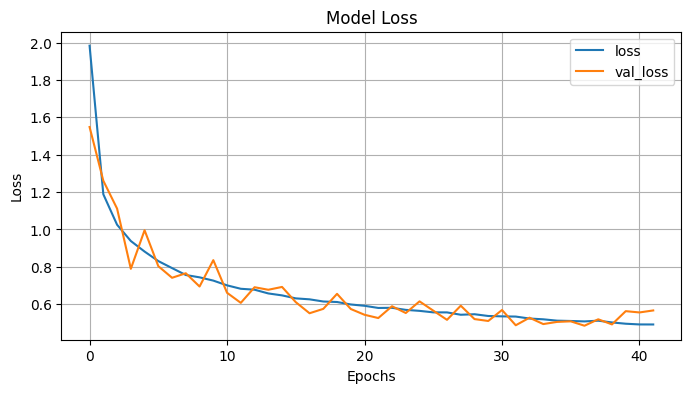

In [22]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid()
plt.show()

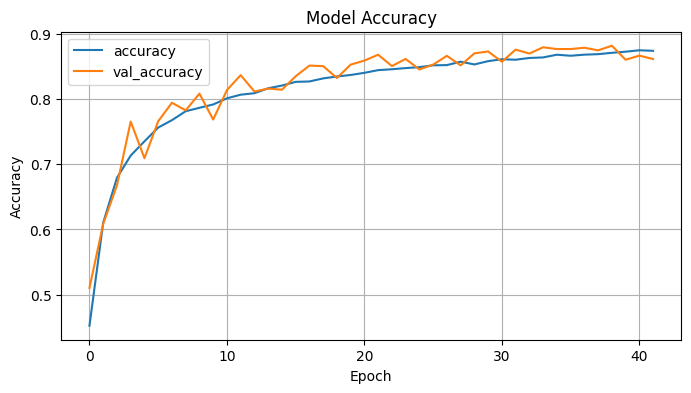

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Model Accuracy")
plt.grid()
plt.show()

In [24]:
preds = model.predict(X_test)
predictions= np.argmax(preds, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [25]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1000
           1       0.96      0.94      0.95      1000
           2       0.88      0.81      0.85      1000
           3       0.84      0.69      0.76      1000
           4       0.91      0.83      0.87      1000
           5       0.85      0.80      0.83      1000
           6       0.77      0.98      0.86      1000
           7       0.88      0.94      0.91      1000
           8       0.94      0.93      0.94      1000
           9       0.89      0.96      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8830 - loss: 0.4816
Accuracy on the test set: 87.88%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 1000x1000 with 0 Axes>

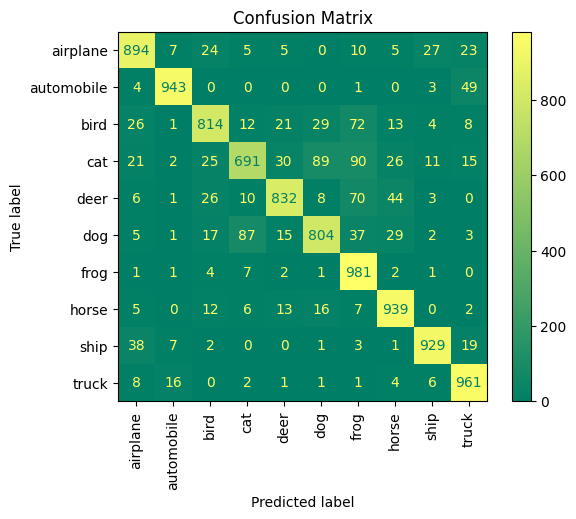

In [26]:
test_metrics = model.evaluate(X_test, y_test)
print(f"Accuracy on the test set: {test_metrics[1] * 100:.2f}%")

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) 

confusion_mat = confusion_matrix(y_test, predicted_classes)

cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=class_names)

plt.figure(figsize=(10, 10))  
cm_display.plot(xticks_rotation='vertical', cmap='summer')
plt.title("Confusion Matrix")  
plt.show()  

# Check the Predictions

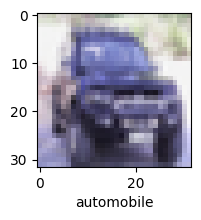

In [27]:
plot_sample(X_test, y_test,9)

In [28]:
class_names[y_prediction_classes[9]]

'automobile'

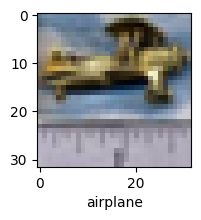

In [29]:
plot_sample(X_test, y_test,675)

In [30]:
class_names[y_prediction_classes[675]]

'ship'

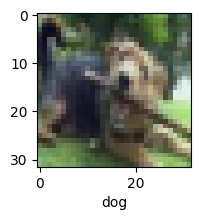

In [31]:
plot_sample(X_test, y_test,1453)

In [32]:
class_names[y_prediction_classes[1453]]

'dog'

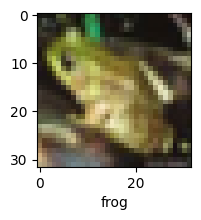

In [33]:
plot_sample(X_test, y_test,2561)

In [34]:
class_names[y_prediction_classes[2561]]

'frog'

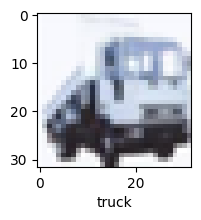

In [35]:
plot_sample(X_test, y_test, 3742)

In [36]:
class_names[y_prediction_classes[3742]]

'truck'

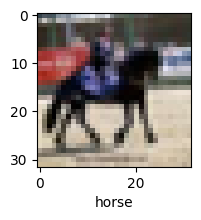

In [37]:
plot_sample(X_test, y_test, 5000)

In [38]:
class_names[y_prediction_classes[5000]]

'horse'

In [39]:
Y_true = y_test  
errors = (y_prediction_classes != Y_true)  

correct_predictions = y_prediction_classes == Y_true

correct_indices = np.where(correct_predictions)[0][:15]

incorrect_indices = np.where(errors)[0][:15]

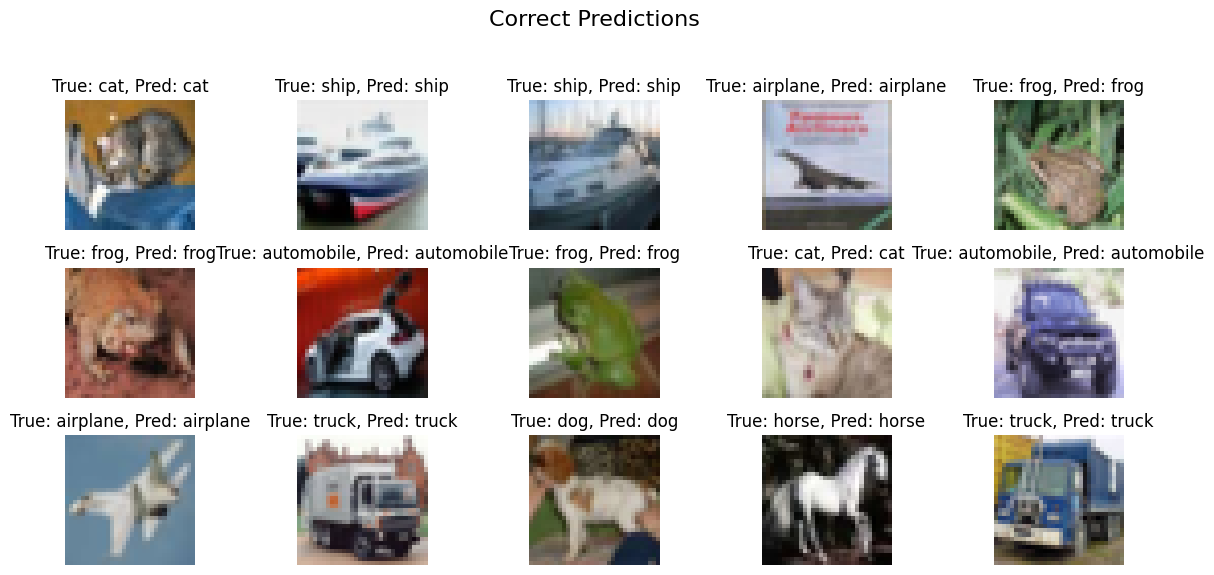

In [40]:
# Lets check the correct predictions

plt.figure(figsize=(12, 6))
plt.suptitle("Correct Predictions", fontsize=16)

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[correct_indices[i]])
    plt.title(f"True: {class_names[Y_true[correct_indices[i]]]}, Pred: {class_names[y_prediction_classes[correct_indices[i]]]}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

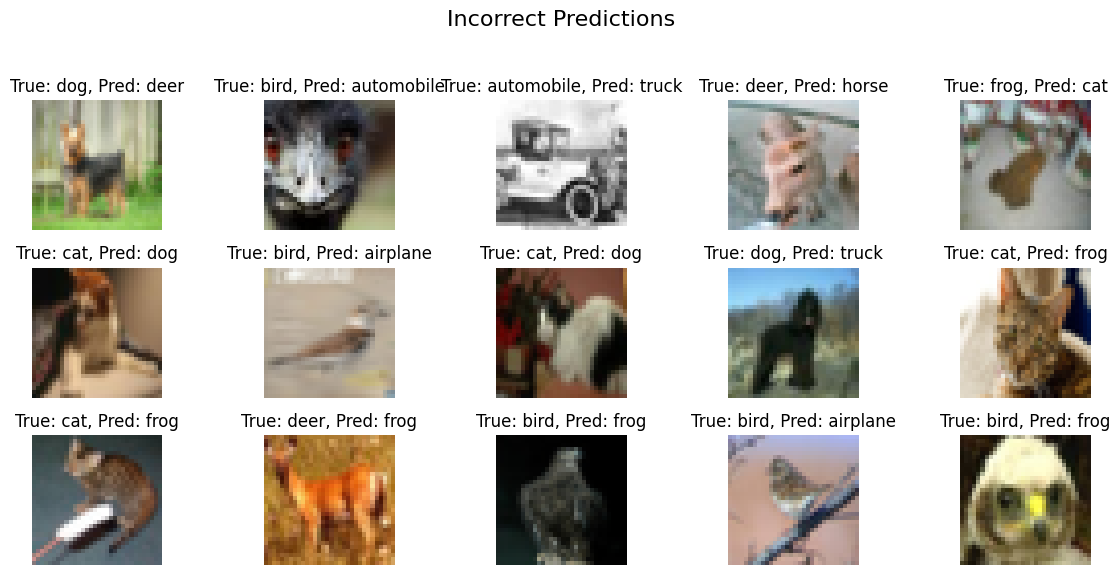

In [41]:
# Lets check the incorrect predictions

plt.figure(figsize=(12, 6))
plt.suptitle("Incorrect Predictions", fontsize=16)

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[incorrect_indices[i]])
    plt.title(f"True: {class_names[Y_true[incorrect_indices[i]]]}, Pred: {class_names[y_prediction_classes[incorrect_indices[i]]]}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Lets Make Some Predictions

In [42]:
def predict_image_from_url(url, model, class_names):
    response = requests.get(url)
    image_data = np.asarray(bytearray(response.content), dtype="uint8")
    image = cv2.imdecode(image_data, cv2.IMREAD_UNCHANGED)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_resized = cv2.resize(image_rgb, (32, 32))

    image_normalized = image_resized.astype('float32') / 255.0

    image_batch = image_normalized.reshape((1, 32, 32, 3))

    prediction = model.predict(image_batch)
    predicted_class = prediction.argmax()
    
    plt.imshow(image_rgb)
    plt.axis('off')  
    plt.title(f"Predicted Class: {class_names[predicted_class]}")
    plt.show()
    
    return class_names[predicted_class]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


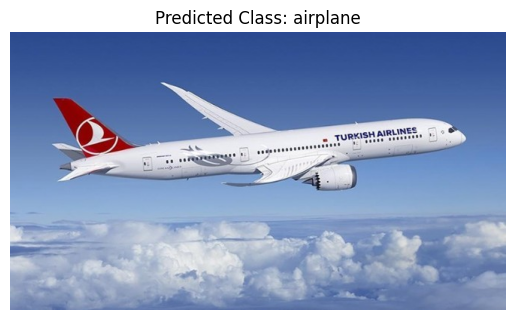

URL: https://www.gercekizmir.com/haber_resim/Pilot-havada-hayatini-kaybetti-Ucak-acil-inis-yapti-159158.jpg -> Predicted Class: airplane


In [43]:
url = "https://www.gercekizmir.com/haber_resim/Pilot-havada-hayatini-kaybetti-Ucak-acil-inis-yapti-159158.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


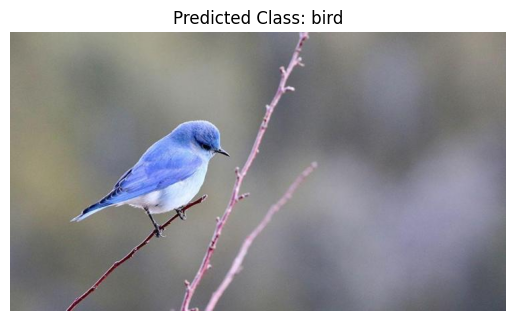

URL: https://image.cnnturk.com/i/cnnturk/75/740x416/60f80d0d214ed81ce85f2a91.jpg -> Predicted Class: bird


In [44]:
url = "https://image.cnnturk.com/i/cnnturk/75/740x416/60f80d0d214ed81ce85f2a91.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


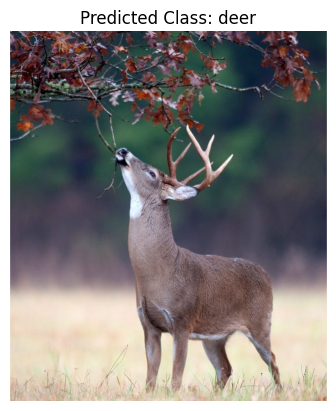

URL: https://ambushhuntingblinds.com/wp-content/uploads/2022/06/shutterstock_71195455-684x800.jpg -> Predicted Class: deer


In [55]:
url = "https://ambushhuntingblinds.com/wp-content/uploads/2022/06/shutterstock_71195455-684x800.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


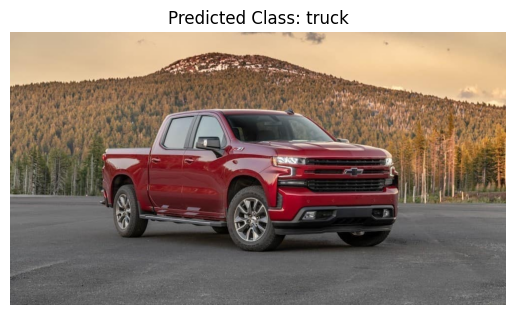

URL: https://di-uploads-pod42.dealerinspire.com/rugeschevrolet/uploads/2023/01/Used-truck-dealer-2020-Chevy-Silverado-1500-Red-1.jpg -> Predicted Class: truck


In [46]:
url = "https://di-uploads-pod42.dealerinspire.com/rugeschevrolet/uploads/2023/01/Used-truck-dealer-2020-Chevy-Silverado-1500-Red-1.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


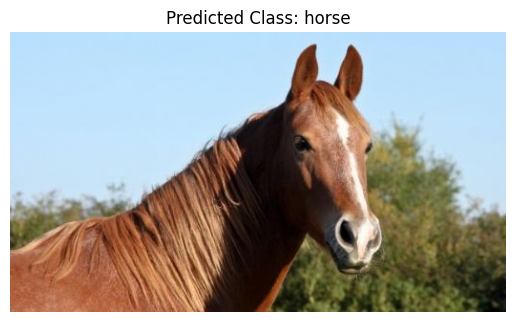

URL: https://www.at.gen.tr/images/At-Turleri-58.jpg -> Predicted Class: horse


In [47]:
url = "https://www.at.gen.tr/images/At-Turleri-58.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


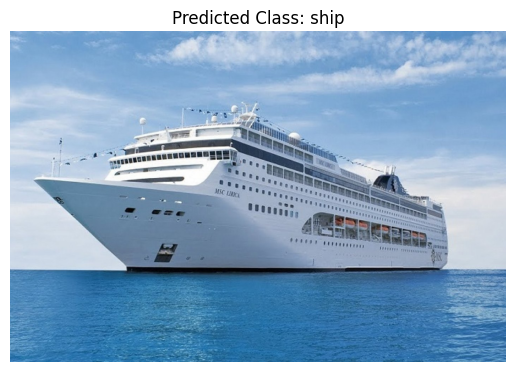

URL: https://images.gemiturlari.info/gemi/turlar/mscliricagemisisol-752019130818.jpg -> Predicted Class: ship


In [48]:
url = "https://images.gemiturlari.info/gemi/turlar/mscliricagemisisol-752019130818.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


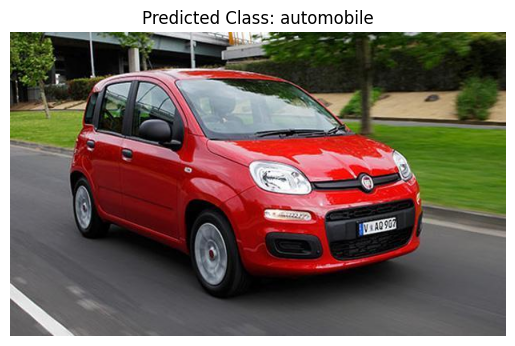

URL: https://image.milimaj.com/i/milliyet/75/0x0/5c8da40145d2a05010d91cab.jpg -> Predicted Class: automobile


In [49]:
url = "https://image.milimaj.com/i/milliyet/75/0x0/5c8da40145d2a05010d91cab.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


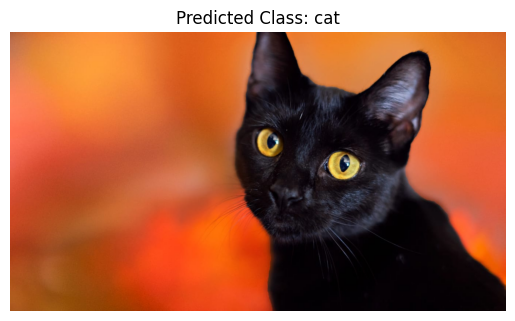

URL: https://images2.minutemediacdn.com/image/upload/c_crop,w_2121,h_1193,x_0,y_0/c_fill,w_1350,ar_16:9,f_auto,q_auto,g_auto/images/voltaxMediaLibrary/mmsport/mentalfloss/01h84ks8b3kn95ybj78q.jpg -> Predicted Class: cat


In [50]:
url = "https://images2.minutemediacdn.com/image/upload/c_crop,w_2121,h_1193,x_0,y_0/c_fill,w_1350,ar_16:9,f_auto,q_auto,g_auto/images/voltaxMediaLibrary/mmsport/mentalfloss/01h84ks8b3kn95ybj78q.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


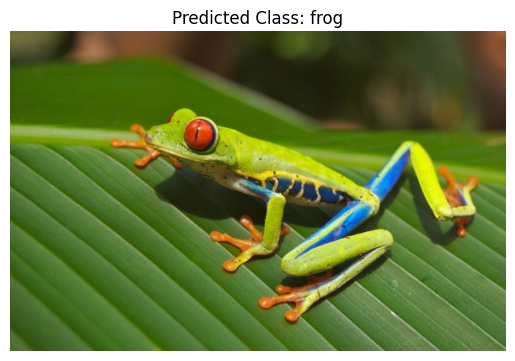

URL: https://images.twinkl.co.uk/tw1n/image/private/t_630/u/ux/frog-1_ver_1.jpg -> Predicted Class: frog


In [51]:
url = "https://images.twinkl.co.uk/tw1n/image/private/t_630/u/ux/frog-1_ver_1.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


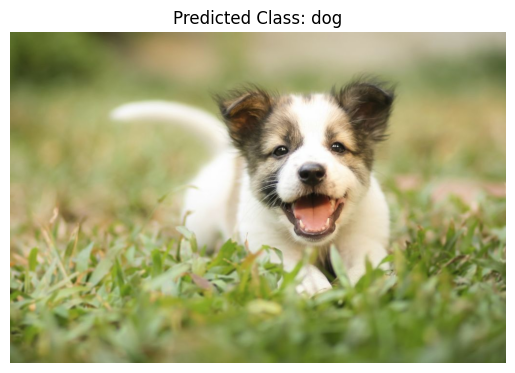

URL: https://res.akamaized.net/domain/image/fetch/t_web/https://static.domain.com.au/domainblog/uploads/2015/01/18225048/choosing-dog-you-home.jpg -> Predicted Class: dog


In [52]:
url = "https://res.akamaized.net/domain/image/fetch/t_web/https://static.domain.com.au/domainblog/uploads/2015/01/18225048/choosing-dog-you-home.jpg"  
predicted_class = predict_image_from_url(url, model, class_names)
print(f"URL: {url} -> Predicted Class: {predicted_class}")

In [53]:
## THANK YOUU